In [1]:
# import libraries
import logging
import os
import warnings
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime
from time import time
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
from random import sample
import random



import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers


warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [2]:
with open('../data_process/captions.txt', 'r') as f:
    next(f)
    captions_doc = f.read()

In [3]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/1978 [00:00<?, ?it/s]

In [4]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('.', '')
            caption = re.sub(r"[^a-zA-Z0-9 ]", "", caption)
            #caption = caption.replace('[^A-Za-z]', '')
            caption =''.join((x for x in caption if not x.isdigit()))
            caption = caption.replace('jmf','')
            caption = caption.replace('xmm','')
            caption = caption.replace('cmmm','')
            caption = caption.replace('xxl','')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            caption = " ".join([word for word in caption.split() if len(word)>2])
            word_tokens = word_tokenize(caption)
            caption = " ".join([w for w in word_tokens if not w.lower() in stop_words])
            captions[i] = caption

In [5]:
clean(mapping)

In [6]:
k = open('../scraping/wildlife keywords.txt','r')
kw = k.readlines()

In [7]:
# list of labels
df = pd.DataFrame(kw)
df = df.rename(columns={0:"labels"})    
df["labels"] = df["labels"].str[:-1]  
df[["labels0","labels1","labels2","labels3"]]= df.labels.str.split("+",expand=True)
df.labels1 = df.labels1.replace('of', None)
lst_labels = df["labels0"].dropna().unique().tolist() +  df["labels1"].dropna().unique().tolist() +  df["labels2"].dropna().unique().tolist()+  df["labels3"].dropna().unique().tolist()


In [8]:
# selecting the labels
from collections import Counter

def labels(mapping,lst_labels,kw):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            word_tokens = word_tokenize(caption)
            caption = " ".join([w for w in word_tokens if w.lower() in lst_labels])
            caption = caption.split(" ")
            UniqW = Counter(caption)
            caption= " ".join(UniqW.keys())
            if not caption:
                caption = kw[int(key.split('_')[1])].replace("+"," ")[:-1]
            caption = caption.split()[random.randint(0, len(caption.split())-1)]
            captions[i] = caption

In [9]:
labels(mapping,lst_labels,kw)

In [10]:
mapping

{'0_545_0_0': ['tiger'],
 '0_545_0_1': ['tiger'],
 '0_545_0_3': ['skull'],
 '0_545_0_2': ['skull'],
 '1_0_0_0': ['alligator'],
 '1_0_0_1': ['leather'],
 '1_0_0_3': ['leather'],
 '1_0_0_2': ['alligator'],
 '1_0_0_6': ['leather'],
 '1_0_0_5': ['leather'],
 '1_0_0_4': ['leather'],
 '1_0_5_1': ['alligator'],
 '1_0_5_0': ['alligator'],
 '1_0_5_2': ['alligator'],
 '1_0_5_3': ['alligator'],
 '11_310_0_0': ['lizard'],
 '11_310_0_1': ['foot'],
 '0_574_6_4': ['turtle'],
 '0_574_6_0': ['turtle'],
 '0_574_6_1': ['turtle'],
 '0_574_6_3': ['turtle'],
 '0_574_6_2': ['turtle'],
 '0_175_19_0': ['elephant'],
 '0_175_22_3': ['elephant'],
 '0_175_22_2': ['elephant'],
 '0_175_22_0': ['elephant'],
 '0_175_22_1': ['elephant'],
 '11_316_3_8': ['python'],
 '11_316_3_9': ['python'],
 '11_316_3_1': ['python'],
 '11_316_3_0': ['python'],
 '11_316_3_2': ['python'],
 '11_316_3_3': ['python'],
 '11_316_3_7': ['python'],
 '11_316_3_6': ['python'],
 '11_316_3_4': ['python'],
 '11_316_3_5': ['python'],
 '0_572_2_1': ['

In [11]:
df = pd.DataFrame.from_dict(mapping.items())
df.columns = ['image_id', 'label']

In [12]:
"""df = pd.DataFrame(columns=['image_id', 'label'])
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id = tokens[0]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    label = image_id.split('_')[1]
    df = df.append({'image_id': image_id, 'label': label}, ignore_index=True)
    """
    

"df = pd.DataFrame(columns=['image_id', 'label'])\n# process lines\nfor line in tqdm(captions_doc.split('\n')):\n    # split the line by comma(,)\n    tokens = line.split(',')\n    if len(line) < 2:\n        continue\n    image_id = tokens[0]\n    # remove extension from image ID\n    image_id = image_id.split('.')[0]\n    label = image_id.split('_')[1]\n    df = df.append({'image_id': image_id, 'label': label}, ignore_index=True)\n    "

In [13]:
df

,image_id,label
0,0_545_0_0,[tiger]
1,0_545_0_1,[tiger]
2,0_545_0_3,[skull]
3,0_545_0_2,[skull]
4,1_0_0_0,[alligator]
...,...,...
1972,0_539_14_1,[tiger]
1973,0_539_14_0,[tiger]
1974,0_539_22_2,[tiger]
1975,0_539_22_0,[tiger]


In [14]:
# Get label frequencies in descending order
label_freq = df['label'].apply(lambda s: str(s).split('|')).explode().value_counts().sort_values(ascending=False)

In [15]:
label_freq

['leather']      197
['taxidermy']    149
['tiger']        146
['tooth']        133
['alligator']    126
['shark']        124
['bone']         123
['crocodile']     64
['skin']          61
['hide']          59
['lizard']        58
['tortoise']      54
['snake']         54
['bear']          45
['foot']          44
['python']        44
['elephant']      39
['skull']         39
['bird']          34
['shell']         33
['fur']           33
['turtle']        33
['teeth']         27
['feather']       26
['hair']          25
['eagle']         24
['cheetah']       23
['feet']          23
['live']          14
['leopard']       14
['lion']          13
['otter']         12
['monkey']        12
['reptile']       10
['claw']          10
['cobra']          9
['egg']            9
['skeleton']       8
['lynx']           7
['falcon']         6
['paw']            6
['tusk']           3
['owl']            1
['horn']           1
['birds']          1
['trophy']         1
Name: label, dtype: int64

In [16]:
"""# Create a list of rare labels
rare_100 = list(label_freq[label_freq > 100].index)
rare_9 = list(label_freq[label_freq < 9].index)
rare = rare_100+rare_9
print("We will be ignoring these rare labels:", rare)"""

'# Create a list of rare labels\nrare_100 = list(label_freq[label_freq > 100].index)\nrare_9 = list(label_freq[label_freq < 9].index)\nrare = rare_100+rare_9\nprint("We will be ignoring these rare labels:", rare)'

In [1]:
"""# Transform label into a list of labels and remove the rare ones
df['label'] = df['label'].apply(lambda s: [l for l in str(s).split('|') if l not in rare])
df = df[df['label'].map(lambda d: len(d)) > 0]
df.head()
"""

"# Transform label into a list of labels and remove the rare ones\ndf['label'] = df['label'].apply(lambda s: [l for l in str(s).split('|') if l not in rare])\ndf = df[df['label'].map(lambda d: len(d)) > 0]\ndf.head()\n"

In [18]:
X_train, X_val, y_train, y_val = train_test_split(df['image_id'], df['label'], test_size=0.2, random_state=44)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

Number of posters for training:  1581
Number of posters for validation:  396


In [19]:
X_train = [os.path.join('images', str(f)+'.jpg') for f in X_train]
X_val = [os.path.join('images', str(f)+'.jpg') for f in X_val]
X_train[:3]

['images/0_0_0_3.jpg', 'images/0_180_4_0.jpg', 'images/0_539_22_2.jpg']

In [20]:
y_train = list(y_train)
y_val = list(y_val)
y_train[:3]

[['alligator'], ['hair'], ['tiger']]

In [21]:
# Fit the multi-label binarizer on the training set
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

Labels:
0. alligator
1. bear
2. bird
3. birds
4. bone
5. cheetah
6. claw
7. cobra
8. crocodile
9. eagle
10. egg
11. elephant
12. falcon
13. feather
14. feet
15. foot
16. fur
17. hair
18. hide
19. horn
20. leather
21. leopard
22. lion
23. live
24. lizard
25. lynx
26. monkey
27. otter
28. owl
29. paw
30. python
31. reptile
32. shark
33. shell
34. skeleton
35. skin
36. skull
37. snake
38. taxidermy
39. teeth
40. tiger
41. tooth
42. tortoise
43. trophy
44. turtle
45. tusk


In [22]:
# transform the targets of the training and test sets
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

In [23]:
# Print examples
for i in range(3):
    print(X_train[i], y_train_bin[i])

images/0_0_0_3.jpg [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
images/0_180_4_0.jpg [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
images/0_539_22_2.jpg [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0]


In [24]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

In [25]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [26]:
BATCH_SIZE = 256 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations


In [27]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset


In [28]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

In [29]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)


Shape of features array: (256, 224, 224, 3)
Shape of labels array: (256, 46)


In [30]:
# Some urls are blocked from untrusted sites, the below code make python environment to trust every site
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

In [31]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))


In [32]:
feature_extractor_layer.trainable = False


In [33]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1311744   
_________________________________________________________________
output (Dense)               (None, 46)                47150     
Total params: 3,616,878
Trainable params: 1,358,894
Non-trainable params: 2,257,984
_________________________________________________________________


In [34]:
for batch in train_ds:
    print(model.predict(batch)[:1])
    break

[[0.6805884  0.45489368 0.41508308 0.39832723 0.32220083 0.40180838
  0.3916796  0.5642411  0.55221087 0.44468915 0.6309793  0.29662699
  0.6682755  0.6274383  0.26973677 0.5052119  0.27652812 0.66098535
  0.42410254 0.7909019  0.62228477 0.6792153  0.44647714 0.537079
  0.5855618  0.21339664 0.43208116 0.48025507 0.5730916  0.61396885
  0.48357564 0.44052476 0.41124406 0.53822416 0.61000603 0.75203085
  0.4631979  0.39423177 0.6002589  0.52466506 0.63335824 0.2988795
  0.5036821  0.7139518  0.51491654 0.37750208]]


In [35]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost


In [36]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [37]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 30

In [38]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=[macro_f1])

In [39]:
start = time()
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=create_dataset(X_val, y_val_bin))


Epoch 1/30
7/7 [==============================] - 100s 9s/step - loss: 0.9611 - macro_f1: 0.0346 - val_loss: 0.9608 - val_macro_f1: 0.0379
Epoch 2/30
7/7 [==============================] - 49s 7s/step - loss: 0.9601 - macro_f1: 0.0368 - val_loss: 0.9601 - val_macro_f1: 0.0378
Epoch 3/30
7/7 [==============================] - 48s 7s/step - loss: 0.9591 - macro_f1: 0.0404 - val_loss: 0.9595 - val_macro_f1: 0.0393
Epoch 4/30
7/7 [==============================] - 48s 7s/step - loss: 0.9583 - macro_f1: 0.0429 - val_loss: 0.9589 - val_macro_f1: 0.0414
Epoch 5/30
7/7 [==============================] - 48s 7s/step - loss: 0.9574 - macro_f1: 0.0455 - val_loss: 0.9583 - val_macro_f1: 0.0458
Epoch 6/30
7/7 [==============================] - 48s 7s/step - loss: 0.9566 - macro_f1: 0.0492 - val_loss: 0.9576 - val_macro_f1: 0.0476
Epoch 7/30
7/7 [==============================] - 52s 8s/step - loss: 0.9558 - macro_f1: 0.0534 - val_loss: 0.9570 - val_macro_f1: 0.0478
Epoch 8/30
7/7 [=================

In [40]:
def print_time(t):
    """Function that converts time period in seconds into %h:%m:%s expression.
    Args:
        t (int): time period in seconds
    Returns:
        s (string): time period formatted
    """
    h = t//3600
    m = (t%3600)//60
    s = (t%3600)%60
    return '%dh:%dm:%ds'%(h,m,s)

In [41]:
print('\nTraining took {}'.format(print_time(time()-start)))



Training took 0h:25m:51s


In [42]:
def learning_curves(history):
    """Plot the learning curves of loss and macro f1 score 
    for the training and validation datasets.
    
    Args:
        history: history callback of fitting a tensorflow keras model 
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    macro_f1 = history.history['macro_f1']
    val_macro_f1 = history.history['val_macro_f1']
    
    epochs = len(loss)

    style.use("bmh")
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs+1), macro_f1, label='Training Macro F1-score')
    plt.plot(range(1, epochs+1), val_macro_f1, label='Validation Macro F1-score')
    plt.legend(loc='lower right')
    plt.ylabel('Macro F1-score')
    plt.title('Training and Validation Macro F1-score')
    plt.xlabel('epoch')

    plt.show()
    
    return loss, val_loss, macro_f1, val_macro_f1

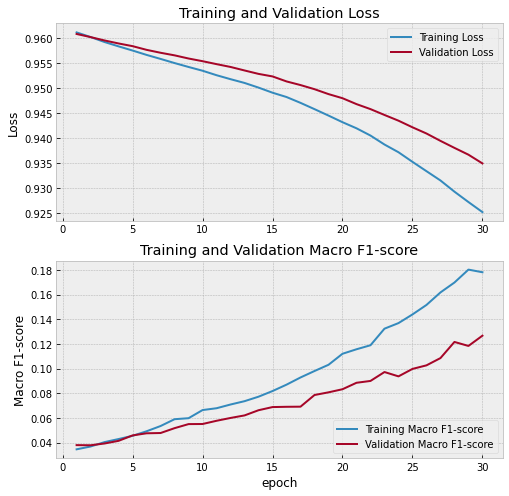

In [43]:
losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(history)


In [44]:
print("Macro soft-F1 loss: %.2f" %val_losses[-1])
print("Macro F1-score: %.2f" %val_macro_f1s[-1])


Macro soft-F1 loss: 0.93
Macro F1-score: 0.13


In [45]:
def show_prediction(path, df, model):
    
    
    img_path = path
    lbl = path.split("/")[1].split(".")[0]
    actual = df.loc[df['image_id']==lbl]['label'].values

    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values

    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.show()
    
    print('\n\nactual\n{}\n\nPrediction\n{}\n'.format(actual, list(prediction)))
    

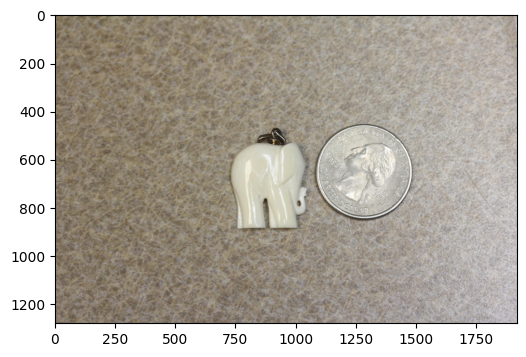



actual
[list(['elephant'])]

Prediction
['birds', 'cobra', 'egg', 'falcon', 'feet', 'hair', 'horn', 'lion', 'live', 'lizard', 'paw', 'skin', 'teeth', 'trophy', 'tusk']



In [46]:
show_prediction('images/0_176_5_2.jpg', df, model)

In [47]:
X_val

['images/0_539_78_1.jpg',
 'images/0_147_14_8.jpg',
 'images/11_31_1_4.jpg',
 'images/0_179_30_2.jpg',
 'images/0_544_8_15.jpg',
 'images/0_555_6_3.jpg',
 'images/0_9_4_3.jpg',
 'images/11_39_2_5.jpg',
 'images/0_306_0_10.jpg',
 'images/11_101_2_0.jpg',
 'images/0_500_28_0.jpg',
 'images/11_1_2_0.jpg',
 'images/1_305_14_3.jpg',
 'images/0_1_1_11.jpg',
 'images/0_500_26_1.jpg',
 'images/0_500_30_1.jpg',
 'images/0_209_1_1.jpg',
 'images/0_306_2_6.jpg',
 'images/0_176_12_0.jpg',
 'images/11_146_1_0.jpg',
 'images/11_44_8_3.jpg',
 'images/0_306_2_7.jpg',
 'images/0_28_0_7.jpg',
 'images/11_0_5_4.jpg',
 'images/11_71_0_1.jpg',
 'images/11_55_0_1.jpg',
 'images/0_498_0_3.jpg',
 'images/0_500_24_0.jpg',
 'images/0_38_0_7.jpg',
 'images/11_253_5_0.jpg',
 'images/11_63_1_2.jpg',
 'images/0_31_46_9.jpg',
 'images/0_402_1_13.jpg',
 'images/0_544_8_7.jpg',
 'images/0_556_8_6.jpg',
 'images/0_0_42_13.jpg',
 'images/11_0_7_6.jpg',
 'images/1_0_0_2.jpg',
 'images/0_555_4_4.jpg',
 'images/0_0_0_14.jp

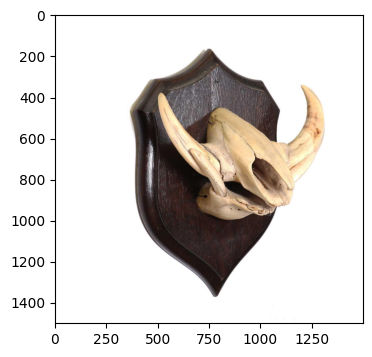



actual
[list(['lizard'])]

Prediction
['bear', 'cobra', 'egg', 'feet', 'hair', 'lion', 'live', 'shell', 'skeleton', 'skin', 'trophy']



In [48]:
show_prediction('images/0_316_0_1.jpg', df, model)

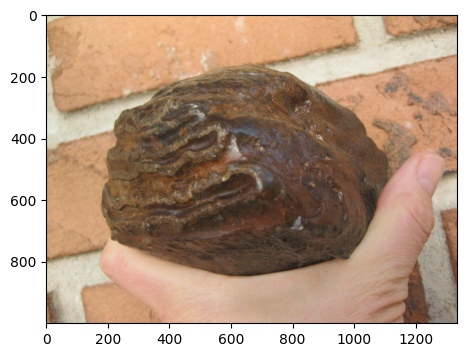



actual
[list(['tooth'])]

Prediction
['birds', 'claw', 'egg', 'feet', 'foot', 'hair', 'horn', 'lion', 'live', 'lizard', 'owl', 'paw', 'shell', 'skin', 'teeth', 'trophy']



In [49]:
show_prediction('images/0_180_12_5.jpg', df, model)

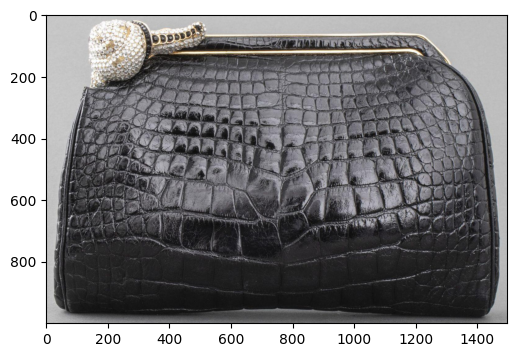



actual
[list(['alligator'])]

Prediction
['alligator', 'birds', 'cobra', 'crocodile', 'egg', 'hair', 'horn', 'leather', 'otter', 'owl', 'python', 'skeleton', 'skin', 'trophy', 'tusk']



In [50]:
show_prediction('images/0_0_42_10.jpg', df, model)